In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
df = pd.read_parquet('Data/price_data/processed/eth_processed_data.parquet')

In [47]:
def bollinger(n):
    df['SMA'] = df['price_close'].rolling(n).mean()
    df['stdev'] = df['price_close'].rolling(n).std()
    df['bollinger'] = (df['price_close'] - df['SMA']) / df['stdev']
    df.drop(columns=['SMA', 'stdev'], inplace=True)

def EMA(n1, n2):
    df['EMA1'] = df['price_close'].ewm(span=n1, adjust=False).mean()
    df['EMA2'] = df['price_close'].ewm(span=n2, adjust=False).mean()
    df['EMAcross'] = df['EMA1'] - df['EMA2']
    df.drop(columns=['EMA1', 'EMA2'], inplace=True)

def RSI(n):
    df['price_close_prev'] = df['price_close'].shift()
    df['U'] = (df['price_close'] - df['price_close_prev']).clip(lower=0)
    df['D'] = (df['price_close_prev'] - df['price_close']).clip(lower=0)
    df['RSI'] = df['U'].rolling(n).mean() / (df['D'].rolling(n).mean() + df['U'].rolling(n).mean())
    df.drop(columns=['price_close_prev', 'U', 'D'], inplace=True)


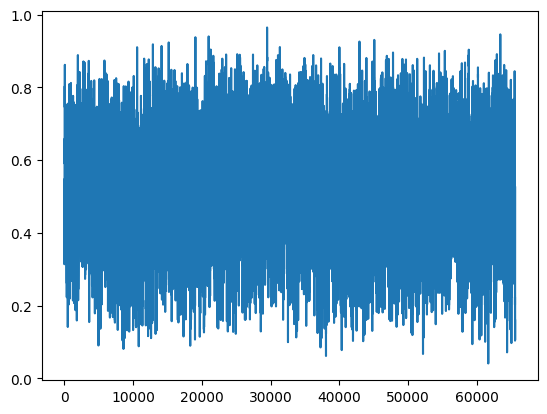

In [49]:
n = 20
bollinger(n)
EMA(5, 30)
RSI(n)
df
plt.plot(df['RSI'])

In [ ]:
coins = set(['arb', 'aval', 'bnb', 'btc', 'eth', 'matic', 'sol', 'tron'])
for coin in coins:
    filepath = f'Data/price_data/processed/{coin}_processed_data.parquet'
    df = pd.read_parquet(filepath)

In [2]:
from datetime import timedelta


def fib_ratio(window, df):
    fib_ratios = [0.236, 0.382, 0.5, 0.618, 0.786]
    fib_data = []
    prices = df['price_close']
    df.index = pd.to_datetime(df.index)

    for time in df.index[window:]:
        try:
            swing_high = df.loc[time - timedelta(days=window):time, 'price_close'].max()
            swing_low = df.loc[time - timedelta(days=window):time, 'price_close'].min()

            price_diff = swing_high - swing_low
            levels = [swing_high - ratio * price_diff for ratio in fib_ratios]

            fib_data.append([time] + levels)

        except Exception as e:
            print(f"Error processing {time}: {e}")
            continue

    columns = ['time_close'] + [f'fib_{int(ratio * 100)}' for ratio in fib_ratios]
    fib_df = pd.DataFrame(fib_data, columns=columns)
    fib_df = fib_df.merge(prices, on='time_close', how='left')

    return fib_df